# Gap Overlap Task: Eye Tracking Preprocessing and Accuracy Analysis


## 1. Setup and Imports


In [115]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr



## 2. Parameters


In [117]:
# Papermill parameters
date = "2025_06_27"
participant_removal_type = "remove_all"
age_group = "all"

## 3. Helper Functions

In [118]:

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc


## 4. Document Setup

In [119]:
# Create a document

doc = docx.Document()


doc = docx.Document()

# Title page
section = doc.sections[0]
#section.start_type = WD_SECTION.ODD_PAGE
#section.orientation = WD_ORIENT.LANDSCAPE
#section.page_width, section.page_height = section.page_height, section.page_width
doc.add_heading('Q1K Gap Task - Eye Tracking Preprocessing', 0)
# Add new doc section with landscape orientation
section = doc.add_section()
section.start_type = WD_SECTION.ODD_PAGE
new_width, new_height = section.page_height, section.page_width
section.orientation = WD_ORIENT.LANDSCAPE
section.page_width = new_width

## 5. Data Loading and Initial Processing

In [120]:
# Load et file
go_df= pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/go_df.csv")

# Save original number of participans
intial_n_participants = go_df["subject"].nunique()
go_df        

,subject,trial_index,condition,side,rt,valid_trials,eeg_age,site,sex,asd,ndd,q1k_ID,group,age_group,min_ntrials,calibration_quality
0,002Z,1,Baseline,Right,230.31,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
1,002Z,2,Gap,Right,255.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
2,002Z,3,Overlap,Left,323.78,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
3,002Z,4,Gap,Right,197.00,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
4,002Z,5,Baseline,Left,372.62,True,45.88,mni,female,0.0,no_ndd,Q1K_002_Z,NaN,adult,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,1256S2,34,Overlap,Right,368.29,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8250,1256S2,35,Gap,Left,247.00,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8251,1256S2,36,Baseline,Right,211.76,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good
8252,1256S2,37,Overlap,Right,319.85,True,18.32,hsj,female,1.0,ndd,Q1K_HSJ_1525-1256_S2,sibling,adult,True,good


## 6. Participant Exclusion Criteria

In [121]:
# Load subjects removed file
subjects_removed_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/missingness/subjects_removed.csv")
subjects_removed_df

,subject,status
0,004_Z,empty file
1,0105F1,empty file
2,1006P,empty file
3,1021F1,empty file
4,1045F1,empty file
5,1052P,empty file
6,1057F1,empty file
7,1089M1,empty file
8,1143S1,empty file
9,1147S2,empty file


In [123]:
# Remove all participants from the subjects_removed df based on tiers of removal
if participant_removal_type == "remove_all": 
    # Remove all participants
    go_df = go_df[~go_df['subject'].isin(subjects_removed_df['subject'].unique())]
elif participant_removal_type == "remove_min_trials":
    # Remove only participants with empty minimum trials
    go_df = go_df[~go_df['subject'].isin(subjects_removed_df[subjects_removed_df['status'].str.contains("trials", na=False)]['subject'].unique())]

In [125]:
# Add how many participants were removed to doc

## Startinng number of participants
doc.add_paragraph(f"Initial number of participants: {intial_n_participants}")
print(f"Initial number of participants: {intial_n_participants}")
# Add how many participants were removed to doc
doc.add_paragraph(f"Participants removed: {intial_n_participants - go_df['subject'].nunique()}")
print(f"Participants removed: {intial_n_participants - go_df['subject'].nunique()}")

# Add how many participants are left to doc
doc.add_paragraph(f"Participants left: {go_df['subject'].nunique()}")
print(f"Participants left: {go_df['subject'].nunique()}")


Initial number of participants: 230
Participants removed: 39
Participants left: 191


## 7. Accuracy Calculations

In [40]:
# Calculate accuracy as proportion of valid trials per participant per condition
# Note: 'valid_trials' column should contain boolean values indicating successful trials
# This calculates: (number of valid trials) / (total trials attempted) per subject/condition

print("Calculating accuracy metrics...")
print(f"Total trials in dataset: {len(go_df)}")
print(f"Valid trials in dataset: {go_df['valid_trials'].sum()}")

# Count valid trials per subject/condition
valid_trials = go_df[go_df.valid_trials == True].groupby(["subject", "condition"])["valid_trials"].count()

# Count total trials per subject/condition  
total_trials = go_df.groupby(["subject", "condition"])["valid_trials"].count()

# Calculate accuracy as proportion
acc_per_sub = valid_trials / total_trials

# Handle missing data (subjects with no valid trials will have NaN)
acc_per_sub = acc_per_sub.fillna(0)

print(f"Accuracy calculated for {len(acc_per_sub)} subject-condition combinations")

Calculating accuracy metrics...
Total trials in dataset: 7785
Valid trials in dataset: 6848
Accuracy calculated for 627 subject-condition combinations


## 8. Descriptive Statistics

In [41]:
# Create summary dataframe
acc_per_sub_s = pd.DataFrame(acc_per_sub).reset_index().rename(columns={"valid_trials": "perc_accuracy"})

# Generate descriptive statistics by condition
acc_descriptive_stats = acc_per_sub_s.groupby(["condition"]).perc_accuracy.describe().reset_index()

# Remove quartiles to improve readability
acc_descriptive_stats = acc_descriptive_stats.drop(columns=["25%", "75%", "50%"])

# Add sample sizes
sample_sizes = acc_per_sub_s.groupby(["condition"]).size().reset_index(name='n_observations')
acc_descriptive_stats = acc_descriptive_stats.merge(sample_sizes, on='condition')

print("Descriptive Statistics by Condition:")
display(acc_descriptive_stats.round(3))


Descriptive Statistics by Condition:


,condition,count,mean,std,min,max,n_observations
0,Baseline,209.0,0.908,0.136,0.333,1.0,209
1,Gap,209.0,0.879,0.135,0.368,1.0,209
2,Overlap,209.0,0.876,0.161,0.368,1.0,209


In [42]:
## Add demographic information to the dataframe

demo_df=go_df[["subject","ndd", "age_group", "sex", "asd", "eeg_age"]].drop_duplicates()
acc_per_sub_s = acc_per_sub_s.merge(demo_df, on="subject", how="left")

In [ ]:
# Descriptive stats for accuracy
doc.add_heading('Accuracy descriptive stats', level=3)
doc = df_to_table(doc, acc_descriptive_stats)


In [44]:
acc_per_sub_s

,subject,condition,perc_accuracy,ndd,age_group,sex,asd,eeg_age
0,002Z,Baseline,1.000000,no_ndd,adult,female,0.0,45.88
1,002Z,Gap,1.000000,no_ndd,adult,female,0.0,45.88
2,002Z,Overlap,0.916667,no_ndd,adult,female,0.0,45.88
3,0042P,Baseline,0.916667,ndd,adult,female,0.0,30.97
4,0042P,Gap,1.000000,ndd,adult,female,0.0,30.97
...,...,...,...,...,...,...,...,...
622,1256S1,Gap,1.000000,ndd,child,male,NaN,17.33
623,1256S1,Overlap,1.000000,ndd,child,male,NaN,17.33
624,1256S2,Baseline,0.923077,ndd,adult,female,1.0,18.32
625,1256S2,Gap,0.923077,ndd,adult,female,1.0,18.32


### 8.1 Overall Accuracy Distribution

<Axes: xlabel='perc_accuracy', ylabel='Density'>

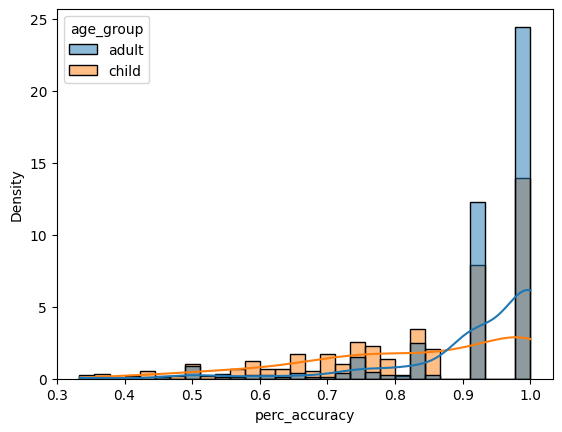

In [45]:
sns.histplot(acc_per_sub_s, x="perc_accuracy", hue="age_group", bins=30, kde=True, stat="density", common_norm=False)

### 8.2 Ceiling Effects Analysis


In [58]:
 # Calculate detailed ceiling effects statistics
ceiling_thresholds = [0.80, 0.90, 0.95, 0.99]

print("Ceiling Effects Analysis:")

for threshold in ceiling_thresholds:
    print(f"\nParticipants with >{threshold*100}% accuracy in ALL conditions:")
    
    for group in ['adult', 'child']:
        if group in acc_per_sub_s['age_group'].values:
            group_df = acc_per_sub_s[acc_per_sub_s['age_group'] == group]
            
            # Count participants above threshold in all conditions
            above_threshold = group_df[group_df['perc_accuracy'] > threshold].groupby('subject').size()
            all_conditions_above = above_threshold[above_threshold == 3]  # Assuming 3 conditions
            
            n_total = group_df['subject'].nunique()
            n_ceiling = len(all_conditions_above)
            percent = n_ceiling / n_total * 100 if n_total > 0 else 0
            
            print(f"  {group.capitalize()}s: {n_ceiling}/{n_total} ({percent:.1f}%)")
            
            # Add to document
            doc.add_paragraph(
                f"{group.capitalize()}s above {threshold*100}%: {n_ceiling}/{n_total} ({percent:.1f}%)",
                style='List Bullet'
            )

# Summary statistics for the document
doc.add_heading('Enhanced Ceiling Effects Analysis', level=3)

Ceiling Effects Analysis:

Participants with >80.0% accuracy in ALL conditions:
  Adults: 97/122 (79.5%)
  Childs: 35/87 (40.2%)

Participants with >90.0% accuracy in ALL conditions:
  Adults: 83/122 (68.0%)
  Childs: 23/87 (26.4%)

Participants with >95.0% accuracy in ALL conditions:
  Adults: 26/122 (21.3%)
  Childs: 7/87 (8.0%)

Participants with >99.0% accuracy in ALL conditions:
  Adults: 26/122 (21.3%)
  Childs: 7/87 (8.0%)


In [47]:
# Subset the data for adults and children
if age_group == "adult":
    acc_per_sub_s = acc_per_sub_s[acc_per_sub_s['age_group'] == 'adult']
elif age_group == "child":
    acc_per_sub_s = acc_per_sub_s[acc_per_sub_s['age_group'] == 'child']
else:
    acc_per_sub_s = acc_per_sub_s

## 9. Statistical Assumptions Testing
### 9.1 Normality Assessment

In [48]:
pg.normality(data=acc_per_sub_s, dv='perc_accuracy', group='condition').round(2)

,W,pval,normal
condition,,,
Baseline,0.72,0.0,False
Gap,0.83,0.0,False
Overlap,0.78,0.0,False


### 9.2 Data Transformations

In [49]:
#Applied various trasnformations
acc_per_sub_s["log_rt"]=np.log(acc_per_sub_s.perc_accuracy)
acc_per_sub_s["sqrt_rt"]=np.sqrt(acc_per_sub_s.perc_accuracy)
acc_per_sub_s["reciprocal_rt"] = boxcox(acc_per_sub_s.perc_accuracy,-0.5)
acc_per_sub_s["arcsine_accuracy"] = np.arcsin(np.sqrt(acc_per_sub_s.perc_accuracy))

<Axes: xlabel='arcsine_accuracy', ylabel='Count'>

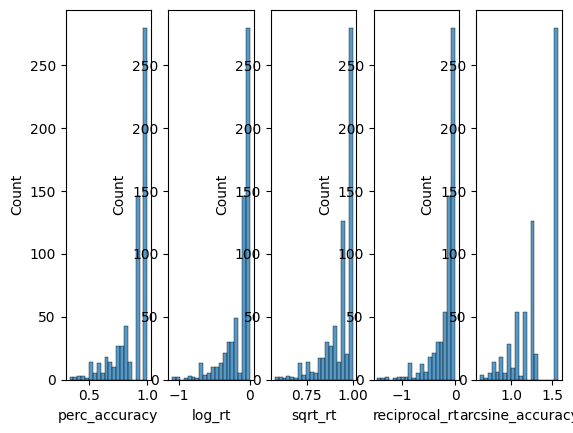

In [50]:
fig, axs = plt.subplots(ncols=5)
sns.histplot(acc_per_sub_s.perc_accuracy,edgecolor='black', bins=20, ax=axs[0])
sns.histplot(acc_per_sub_s.log_rt,edgecolor='black', bins=20, ax=axs[1])
sns.histplot(acc_per_sub_s.sqrt_rt,edgecolor='black', bins=20, ax=axs[2])
sns.histplot(acc_per_sub_s.reciprocal_rt,edgecolor='black', bins=20, ax=axs[3])
sns.histplot(acc_per_sub_s.arcsine_accuracy, edgecolor='black', bins=20, ax=axs[4])


In [23]:
results_df=pg.normality(data=acc_per_sub_s, dv='perc_accuracy', group='condition')
results_df

,W,pval,normal
condition,,,
Baseline,0.716124,1.312832e-18,False
Gap,0.826889,1.649613e-14,False
Overlap,0.778292,1.723470e-16,False


In [24]:
## Add table to the document
doc.add_heading('Normality test', level=3)

doc = df_to_table(doc, results_df)

# Add bullet point to the document

doc.add_paragraph("Not normally distributed: suggest non-parametric", style='List Bullet')

### 9.3 Homoscedasticity and Sphericity Tests

In [25]:
# Perform Levene's test for homogeneity of variance
pg.homoscedasticity(data=acc_per_sub_s, dv='perc_accuracy', group='ndd', method='levene')

,W,pval,equal_var
levene,18.620772,0.000019,False


In [26]:
# Add assumption results to the document as bullet points

doc.add_paragraph(f"Sphericity: {pg.sphericity(data=acc_per_sub_s, dv='perc_accuracy', subject='subject', within='condition')[-1]}", style='List Bullet')


## 10. Main Statistical Analyses
### 10.1 Overall Condition Differences (Friedman Test)

In [27]:
### Friedman Test (non-parametric)
pg.friedman(data=acc_per_sub_s, dv="perc_accuracy", within="condition", subject="subject").round(3)

,Source,W,ddof1,Q,p-unc
Friedman,condition,0.055,2,23.085,0.0


In [28]:
doc.add_heading('Friedman test for each group and condition', level=3)


In [29]:
# Add to the document
doc.add_paragraph('Friedman test for each condition across participants', style='List Bullet')

# Add table to the document
doc = df_to_table(doc, pg.friedman(data=acc_per_sub_s, dv="perc_accuracy", within="condition", subject="subject").round(3))

In [30]:
acc_per_sub_s

,subject,condition,perc_accuracy,ndd,age_group,sex,asd,eeg_age,log_rt,sqrt_rt,reciprocal_rt
0,002Z,Baseline,1.000000,no_ndd,adult,female,0.0,45.88,0.000000,1.000000,0.000000
1,002Z,Gap,1.000000,no_ndd,adult,female,0.0,45.88,0.000000,1.000000,0.000000
2,002Z,Overlap,0.916667,no_ndd,adult,female,0.0,45.88,-0.087011,0.957427,-0.088932
3,0042P,Baseline,0.916667,ndd,adult,female,0.0,30.97,-0.087011,0.957427,-0.088932
4,0042P,Gap,1.000000,ndd,adult,female,0.0,30.97,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
622,1256S1,Gap,1.000000,ndd,child,male,NaN,17.33,0.000000,1.000000,0.000000
623,1256S1,Overlap,1.000000,ndd,child,male,NaN,17.33,0.000000,1.000000,0.000000
624,1256S2,Baseline,0.923077,ndd,adult,female,1.0,18.32,-0.080043,0.960769,-0.081666
625,1256S2,Gap,0.923077,ndd,adult,female,1.0,18.32,-0.080043,0.960769,-0.081666


### 10.2 Post-hoc Pairwise Comparisons

In [31]:
# Pivot the data to wide format: rows=subject, columns=condition, values=perc_accuracy
acc_wide = acc_per_sub_s.pivot(index="subject", columns="condition", values="perc_accuracy")

# Run posthoc Conover-Friedman test
posthocs = sp.posthoc_conover_friedman(acc_wide, p_adjust="fdr_bh")

# Reset index for display
posthocs = posthocs.reset_index().rename(columns={'index': 'Condition'})
posthocs

# Write notes
doc.add_paragraph("Post-hoc Conover-Friedman test results", style='List Bullet')
# Add table to the document
doc = df_to_table(doc, posthocs)

# Add bullet point to the document
if posthocs.iloc[:, 1:].isnull().values.any():
    doc.add_paragraph("Post-hoc Conover-Friedman test results: no significant differences between conditions", style='List Bullet')
    print("Post-hoc Conover-Friedman test results: no significant differences between conditions")
else:
    doc.add_paragraph("Post-hoc Conover-Friedman test results: significant differences between conditions", style='List Bullet')
    print("Post-hoc Conover-Friedman test results: *** significant differences between conditions")

# Add which contrasts are significant
conditions = posthocs['Condition'].tolist()
for i in range(len(conditions)):
    for j in range(i+1, len(conditions)):
        pval = posthocs.iloc[i, j+1]  # +1 because first column is 'Condition'
        if pval < 0.05:
            doc.add_paragraph(f"Significant difference between {conditions[i]} and {conditions[j]}: p={pval:.3g}", style='List Bullet')
            print(f"Significant difference between {conditions[i]} and {conditions[j]}: p={pval:.3g}")

Post-hoc Conover-Friedman test results: *** significant differences between conditions
Significant difference between Baseline and Gap: p=1.11e-05
Significant difference between Baseline and Overlap: p=0.000424


### 10.3 Group-Specific Analyses
#### 10.3.1 NDD Group Analysis

In [32]:
# Friedman for each group and condition

#NDD
print ("Friedmans for NDD")
pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.ndd=="ndd"] , dv="perc_accuracy", within="condition", subject="subject").round(3)


Friedmans for NDD


,Source,W,ddof1,Q,p-unc
Friedman,condition,0.049,2,9.919,0.007


#### 10.3.2 Control Group Analysis

In [33]:
#Control
print ("Friedmans for Control")
pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.ndd=="no_ndd"] , dv="perc_accuracy", within="condition", subject="subject").round(3)


Friedmans for Control


,Source,W,ddof1,Q,p-unc
Friedman,condition,0.064,2,13.599,0.001


### 10.4 Between-Group Comparisons


In [34]:
# Add resuls to the document

# Add bullet points
doc.add_paragraph('Friedman test NDD group', style='List Bullet')

# Add table to the document
doc = df_to_table(doc, pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.ndd=="ndd"] , dv="perc_accuracy", within="condition", subject="subject").round(3))

doc.add_paragraph('Friedman test Control group', style='List Bullet')
doc = df_to_table(doc, pg.friedman(data=acc_per_sub_s.loc[acc_per_sub_s.ndd=="no_ndd"] , dv="perc_accuracy", within="condition", subject="subject").round(3))


In [35]:
# Mann Whitney U test for each differeences between groups for each condition 
pg.pairwise_ttests(data=acc_per_sub_s, dv='perc_accuracy', between='ndd', within='condition', subject='subject', parametric=False, padjust='fdr_bh').round(3)

c:\Users\gabot\OneDrive - McGill University\Desktop\Github_repos\q1k_neurosubs\q1k_et_neurosubs_env\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,condition,A,B,Paired,Parametric,U-val,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,condition,-,Baseline,Gap,True,False,NaN,3353.5,two-sided,0.000,0.000,fdr_bh,0.214
1,condition,-,Baseline,Overlap,True,False,NaN,2079.5,two-sided,0.000,0.001,fdr_bh,0.215
2,condition,-,Gap,Overlap,True,False,NaN,5136.0,two-sided,0.867,0.867,fdr_bh,0.021
3,ndd,-,ndd,no_ndd,False,False,3752.0,NaN,two-sided,0.000,NaN,NaN,-0.536
4,condition * ndd,Baseline,ndd,no_ndd,False,False,3925.0,NaN,two-sided,0.000,0.000,fdr_bh,-0.467
5,condition * ndd,Gap,ndd,no_ndd,False,False,4175.0,NaN,two-sided,0.002,0.002,fdr_bh,-0.441
6,condition * ndd,Overlap,ndd,no_ndd,False,False,4164.5,NaN,two-sided,0.002,0.002,fdr_bh,-0.484


## 11. Data Visualization
### 11.1 Main Accuracy Plot

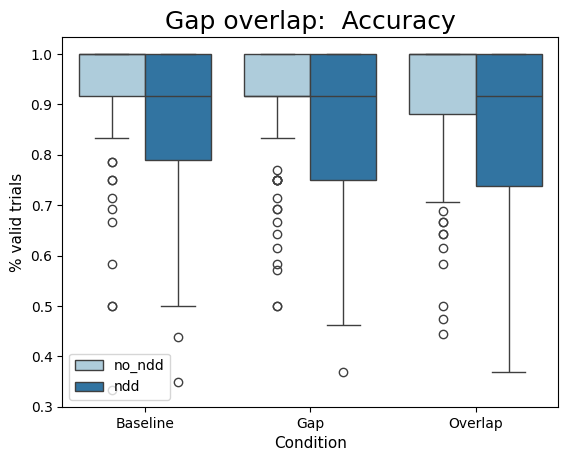

In [36]:
sns.boxplot(x="condition", y="perc_accuracy", data=acc_per_sub_s, palette="Paired", hue="ndd", 
        ).set_title('Gap overlap:  Accuracy',fontsize=18)

plt.grid(False)
plt.ylabel('% valid trials',fontsize=11)
plt.xlabel('Condition',fontsize=11)
plt.legend(loc='lower left')

#plt.ylim([0.7,1.2])

# Save the figure
plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/accuracy_conditions.png")
plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/archive/accuracy_conditions_{date}.png")


plt.show()

# Add the figure to the document
doc.add_heading('Accuracy figure ', level=4)

doc.add_picture(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/accuracy_conditions.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))



### 11.2 Exploratory Plots by Demographics

C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\308830699.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue = "ndd", ax=ax[0],
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\308830699.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue ="age_group", ax=ax[1],
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\308830699.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue= "sex", ax=ax[2],
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\308830699.py:15: FutureWarning: 



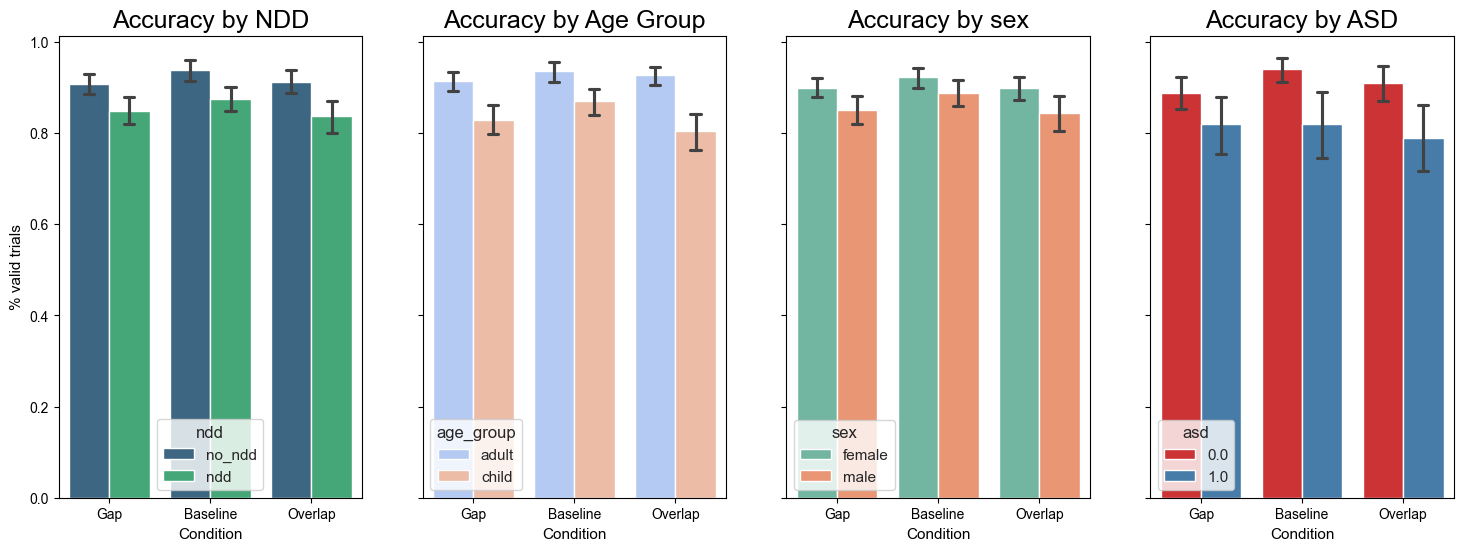

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
sns.set_theme(style="white")

order = ["Gap", "Baseline","Overlap"]
sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue = "ndd", ax=ax[0],
            palette="viridis").set_title("",fontsize=18)

sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue ="age_group", ax=ax[1],
            palette="coolwarm").set_title("",fontsize=18)

sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue= "sex", ax=ax[2],
            palette="Set2").set_title("",fontsize=18)

# Test ASD  vs Control
sns.barplot(x="condition", y="perc_accuracy", data=acc_per_sub_s,order=order,estimator=np.mean, ci=95, capsize=.2, hue = "asd", ax=ax[3],
            palette="Set1",
            ).set_title("",fontsize=18)



# Add titles to the plots
ax[0].set_title('Accuracy by NDD',fontsize=18)
ax[1].set_title('Accuracy by Age Group',fontsize=18)
ax[2].set_title('Accuracy by sex',fontsize=18)
ax[3].set_title('Accuracy by ASD',fontsize=18)

# Add labels to the plots
ax[0].set_ylabel('% valid trials',fontsize=11)
ax[1].set_ylabel('% valid trials',fontsize=11)
ax[2].set_ylabel('% valid trials',fontsize=11)
ax[3].set_ylabel('% valid trials',fontsize=11)

ax[0].set_xlabel('Condition',fontsize=11)
ax[1].set_xlabel('Condition',fontsize=11)
ax[2].set_xlabel('Condition',fontsize=11)
ax[3].set_xlabel('Condition',fontsize=11)

# Save and add to doc 
plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/accuracy_conditions_grouped.png")

plt.show()

# Add the figure to the document
doc.add_heading('Accuracy Figure by Demographics', level=4)

doc.add_picture(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/accuracy_conditions_grouped.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))

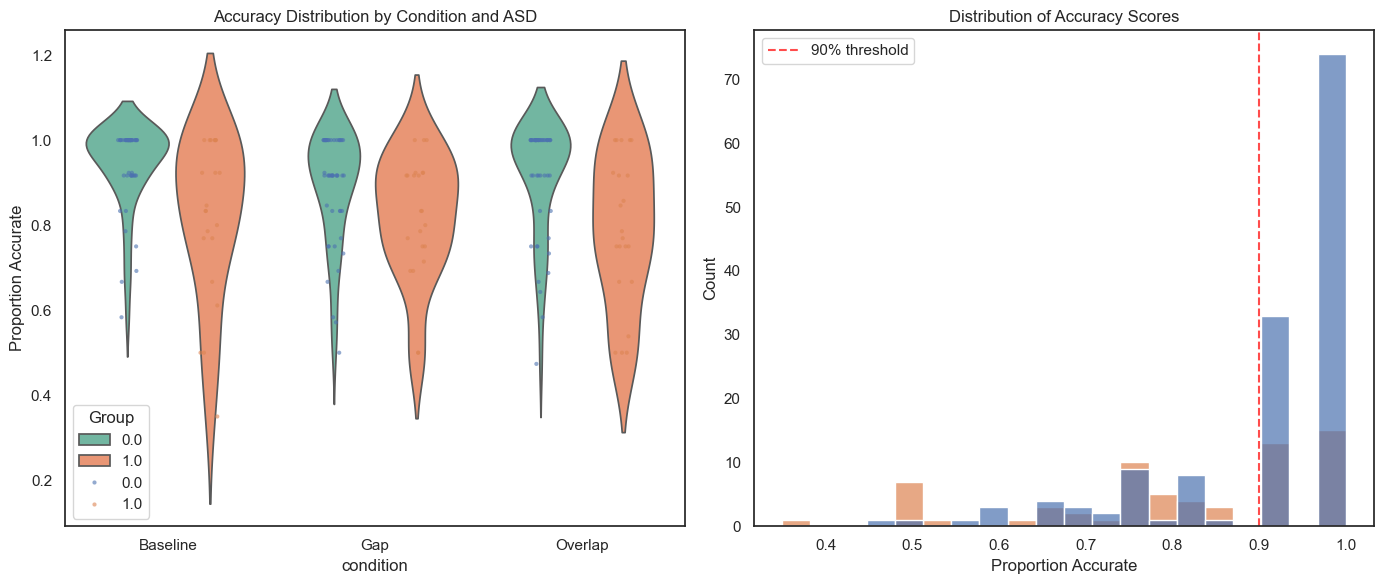

In [60]:
### 11.3 Specialized Plots for Ceiling Effects

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot with individual points
sns.violinplot(data=acc_per_sub_s, x="condition", y="perc_accuracy", hue="asd", 
               ax=axes[0], palette="Set2", inner=None)
sns.stripplot(data=acc_per_sub_s, x="condition", y="perc_accuracy", hue="asd", 
              ax=axes[0], dodge=True, alpha=0.6, size=3)

axes[0].set_title('Accuracy Distribution by Condition and ASD')
axes[0].set_ylabel('Proportion Accurate')
axes[0].legend(title='Group')

# Histogram showing ceiling effects
sns.histplot(data=acc_per_sub_s, x="perc_accuracy", hue="asd", 
             bins=20, alpha=0.7, ax=axes[1])
axes[1].axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='90% threshold')
axes[1].set_title('Distribution of Accuracy Scores')
axes[1].set_xlabel('Proportion Accurate')
axes[1].legend()

plt.tight_layout()
plt.show()

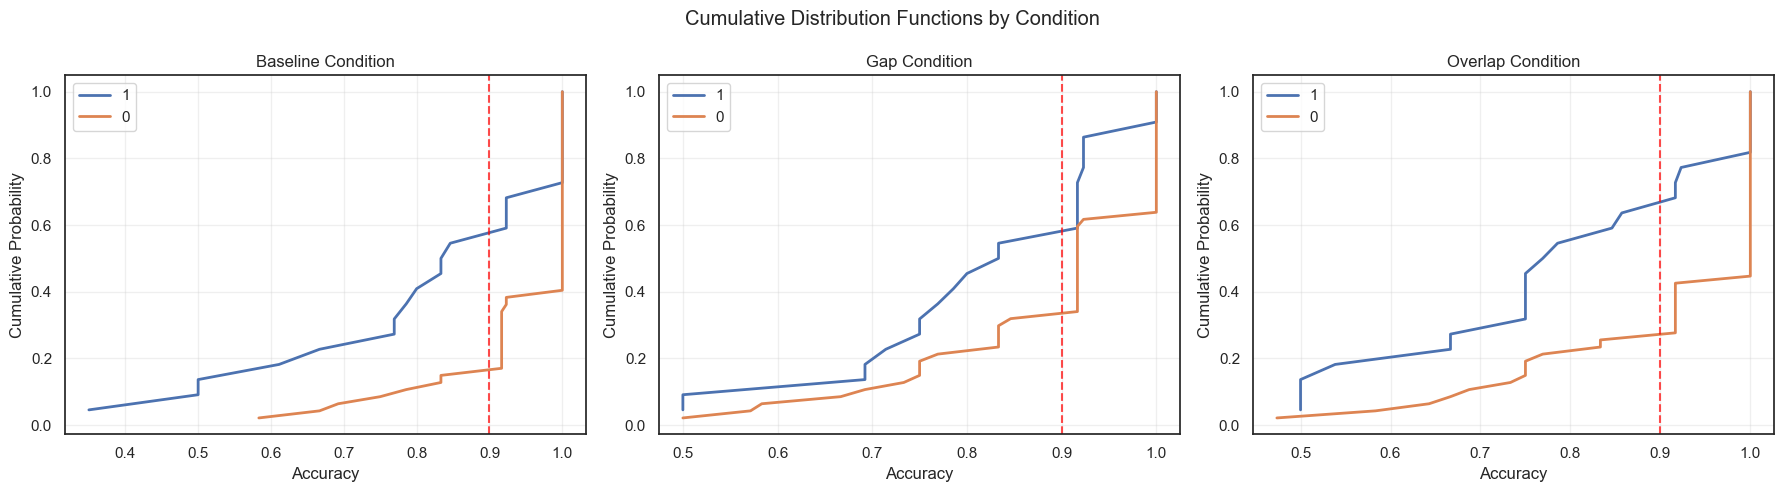

In [61]:
# Cumulative distribution functions to show ceiling effects
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

conditions = acc_per_sub_s['condition'].unique()

for i, condition in enumerate(conditions):
    data_subset = acc_per_sub_s[acc_per_sub_s['condition'] == condition]
    
    for group in [1,0]:
        group_data = data_subset[data_subset['asd'] == group]['perc_accuracy']
        if len(group_data) > 0:
            # Calculate ECDF
            x = np.sort(group_data)
            y = np.arange(1, len(x) + 1) / len(x)
            axes[i].plot(x, y, label=f'{group}', linewidth=2)
    
    axes[i].axvline(x=0.9, color='red', linestyle='--', alpha=0.7)
    axes[i].set_title(f'{condition} Condition')
    axes[i].set_xlabel('Accuracy')
    axes[i].set_ylabel('Cumulative Probability')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Cumulative Distribution Functions by Condition')
plt.tight_layout()
plt.show()

## 12. Descriptive Statistics by Groups
### 12.1 By Neurodevelopmental Status

In [51]:
### 12.1 By Neurodevelopmental Status

# Descriptive statistics by NDD group
desc_ndd = acc_per_sub_s.groupby(['condition', 'ndd'])['perc_accuracy'].agg(
    n='count', mean='mean', sd='std', min='min', max='max'
).reset_index()

# Add to document
doc.add_heading('Descriptive Statistics by NDD Group', level=3)
doc = df_to_table(doc, desc_ndd.round(3))

print("Descriptive statistics by NDD group:")
display(desc_ndd.round(3))

Descriptive statistics by NDD group:


,condition,ndd,n,mean,sd,min,max
0,Baseline,ndd,102,0.876,0.146,0.350,1.0
1,Baseline,no_ndd,107,0.938,0.119,0.333,1.0
2,Gap,ndd,102,0.849,0.146,0.368,1.0
3,Gap,no_ndd,107,0.907,0.117,0.500,1.0
4,Overlap,ndd,102,0.837,0.181,0.368,1.0
5,Overlap,no_ndd,107,0.913,0.131,0.444,1.0


### 12.2 By Age Group

In [38]:

# By Age Group
desc_age = acc_per_sub_s.groupby(['condition', 'age_group'])['perc_accuracy'].agg(
    n='count', mean='mean', sd='std', min='min', max='max'
).reset_index()

doc.add_heading('Descriptive stats by Age Group', level=3)
doc = df_to_table(doc, desc_age.round(3))
desc_age


,condition,age_group,n,mean,sd,min,max
0,Baseline,adult,122,0.935303,0.125468,0.333333,1.0
1,Baseline,child,87,0.869448,0.142599,0.437500,1.0
2,Gap,adult,122,0.914163,0.115752,0.500000,1.0
3,Gap,child,87,0.829266,0.145419,0.368421,1.0
4,Overlap,adult,122,0.926670,0.117247,0.444444,1.0
5,Overlap,child,87,0.804100,0.186611,0.368421,1.0


In [38]:
### 12.3 By Sex
desc_sex = acc_per_sub_s.groupby(['condition', 'sex'])['perc_accuracy'].agg(
    n='count', mean='mean', sd='std', min='min', max='max'
).reset_index()

doc.add_heading('Descriptive stats by Sex', level=3)
doc = df_to_table(doc, desc_sex.round(3))
desc_sex





,condition,sex,n,mean,sd,min,max
0,Baseline,female,118,0.922207,0.135044,0.333333,1.0
1,Baseline,male,90,0.888095,0.137071,0.437500,1.0
2,Gap,female,118,0.899676,0.123423,0.461538,1.0
3,Gap,male,90,0.851061,0.146168,0.368421,1.0
4,Overlap,female,118,0.898422,0.141130,0.428571,1.0
5,Overlap,male,90,0.844407,0.181327,0.368421,1.0


In [39]:
### 12.4 By ASD Status

desc_asd = acc_per_sub_s.groupby(['condition', 'asd'])['perc_accuracy'].agg(
    n='count', mean='mean', sd='std', min='min', max='max'
).reset_index()

doc.add_heading('Descriptive stats by ASD', level=3)
doc = df_to_table(doc, desc_asd.round(3))
desc_asd


,condition,asd,n,mean,sd,min,max
0,Baseline,0.0,47,0.941295,0.099534,0.583333,1.0
1,Baseline,1.0,22,0.819727,0.190149,0.350000,1.0
2,Gap,0.0,47,0.889054,0.129999,0.500000,1.0
3,Gap,1.0,22,0.820746,0.142984,0.500000,1.0
4,Overlap,0.0,47,0.910779,0.134793,0.473684,1.0
5,Overlap,1.0,22,0.790293,0.173315,0.500000,1.0


## 13. Developmental Trajectory Analysis


In [41]:
acc_per_sub_s

,subject,condition,perc_accuracy,ndd,age_group,sex,asd,eeg_age,log_rt,sqrt_rt,reciprocal_rt
0,002Z,Baseline,1.000000,no_ndd,adult,female,0.0,45.88,0.000000,1.000000,0.000000
1,002Z,Gap,1.000000,no_ndd,adult,female,0.0,45.88,0.000000,1.000000,0.000000
2,002Z,Overlap,0.916667,no_ndd,adult,female,0.0,45.88,-0.087011,0.957427,-0.088932
3,0042P,Baseline,0.916667,ndd,adult,female,0.0,30.97,-0.087011,0.957427,-0.088932
4,0042P,Gap,1.000000,ndd,adult,female,0.0,30.97,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
622,1256S1,Gap,1.000000,ndd,child,male,NaN,17.33,0.000000,1.000000,0.000000
623,1256S1,Overlap,1.000000,ndd,child,male,NaN,17.33,0.000000,1.000000,0.000000
624,1256S2,Baseline,0.923077,ndd,adult,female,1.0,18.32,-0.080043,0.960769,-0.081666
625,1256S2,Gap,0.923077,ndd,adult,female,1.0,18.32,-0.080043,0.960769,-0.081666


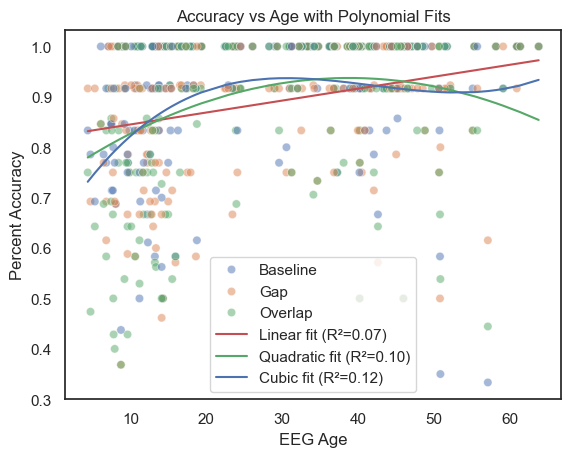

In [42]:

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Scatterplot
sns.scatterplot(x="eeg_age", y="perc_accuracy", data=acc_per_sub_s, hue="condition", alpha=0.5)

# Fit polynomial models and plot
x = acc_per_sub_s["eeg_age"]
y = acc_per_sub_s["perc_accuracy"]

# Try linear, quadratic, and cubic fits
degrees = [1, 2, 3]
colors = ['r', 'g', 'b']
labels = ['Linear', 'Quadratic', 'Cubic']

for deg, color, label in zip(degrees, colors, labels):
    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    y_pred = poly(np.sort(x))
    plt.plot(np.sort(x), y_pred, color=color, label=f"{label} fit (R²={r2_score(y, poly(x)):.2f})")

plt.legend()
plt.title("Accuracy vs Age with Polynomial Fits")
plt.xlabel("EEG Age")
plt.ylabel("Percent Accuracy")
plt.show()

## 14. Data Export for Further Analysis

In [84]:
# Convert to wide and save 

acc_wide = acc_per_sub_s.pivot(index="subject", columns="condition", values="perc_accuracy")

# Rename for clarity so that they can be used later as features for subgrouping analyses
acc_wide = acc_wide.rename(columns={
    "Gap": "gap_accuracy",
    "Baseline": "baseline_accuracy",
    "Overlap": "overlap_accuracy"
})

# Compute overall accuracy
acc_wide["overall_accuracy"] = acc_wide.mean(axis=1)
acc_wide

condition,baseline_accuracy,gap_accuracy,overlap_accuracy,overall_accuracy
subject,,,,
002Z,1.000000,1.000000,0.916667,0.972222
0042P,0.916667,1.000000,1.000000,0.972222
0043F1,1.000000,1.000000,1.000000,1.000000
0050M1,1.000000,1.000000,0.916667,0.972222
0050P,0.687500,0.687500,0.916667,0.763889
...,...,...,...,...
1226M2,1.000000,1.000000,1.000000,1.000000
1256F1,0.857143,0.916667,1.000000,0.924603
1256P,1.000000,0.714286,0.538462,0.750916


# 15. Check correlation between all variables

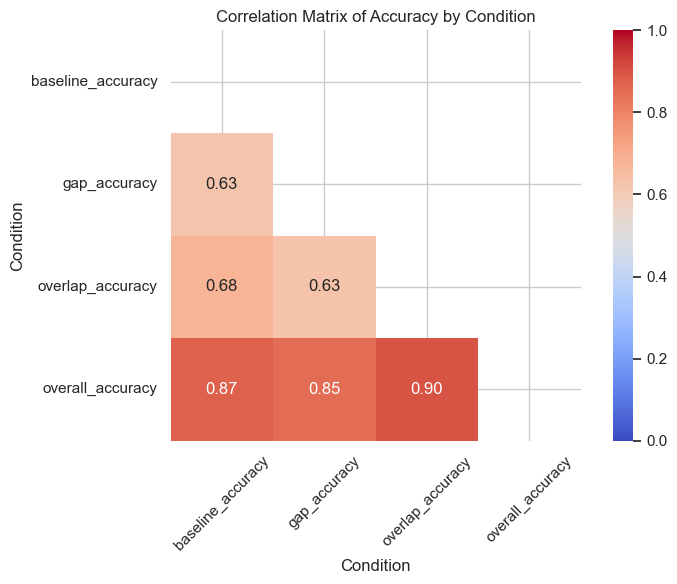

P-values for correlations:


condition,baseline_accuracy,gap_accuracy,overlap_accuracy,overall_accuracy
condition,,,,
baseline_accuracy,1.0,0.0,0.0,0.0
gap_accuracy,0.0,1.0,0.0,0.0
overlap_accuracy,0.0,0.0,1.0,0.0
overall_accuracy,0.0,0.0,0.0,1.0


In [110]:

# Compute correlation matrix and p-value matrix
corr = acc_wide.corr()
pvals = np.ones(corr.shape)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j:
            x = acc_wide.iloc[:, i]
            y = acc_wide.iloc[:, j]
            r, p = pearsonr(x, y)
            corr.iloc[i, j] = r
            pvals[i, j] = p

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    square=True, 
    mask=mask, 
    vmin=0, vmax=1, 
)


plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Condition")
plt.ylabel("Condition")
plt.title("Correlation Matrix of Accuracy by Condition")
plt.tight_layout()
plt.savefig("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/correlation_matrix_accuracy.png")
plt.show()

# Print the p-values as a table
print("P-values for correlations:")
display(pd.DataFrame(pvals, index=corr.index, columns=corr.columns).round(3))

# 16. Plot overall acuracy per group

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
sns.set_theme(style="whitegrid")

# Prepare data
acc_long = acc_wide.reset_index().melt(
    id_vars=["subject"], 
    value_vars=["gap_accuracy", "baseline_accuracy", "overlap_accuracy", "overall_accuracy"],
    var_name="condition",
    value_name="perc_accuracy"
)
acc_long = acc_long.merge(demo_df, on="subject", how="left")
acc_long = acc_long[acc_long["condition"] == "overall_accuracy"]

# Colorblind-friendly palettes
palettes = [
    "colorblind",   # NDD
    "pastel",       # Age Group
    "Dark2",        # Sex
    "tab10"         # ASD
]

# Plot NDD
sns.barplot(
    x="ndd", y="perc_accuracy", data=acc_long, 
    order=["ndd", "no_ndd"], estimator=np.mean, ci=95, capsize=.2, 
    hue="ndd", ax=ax[0], palette=palettes[0], legend=False
)
 
ax[0].set_title('Overall Accuracy by NDD', fontsize=16)
ax[0].set_xlabel('NDD', fontsize=13)
ax[0].set_ylabel('Overall Accuracy', fontsize=13)

# Plot Age Group
sns.barplot(
    x="age_group", y="perc_accuracy", data=acc_long, 
    order=["adult", "child"], estimator=np.mean, ci=95, capsize=.2, 
    hue="age_group", ax=ax[1], palette=palettes[1], legend=False
)
 
ax[1].set_title('Overall Accuracy by Age Group', fontsize=16)
ax[1].set_xlabel('Age Group', fontsize=13)
ax[1].set_ylabel('')

# Plot Sex
sns.barplot(
    x="sex", y="perc_accuracy", data=acc_long, 
    estimator=np.mean, ci=95, capsize=.2, 
    hue="sex", ax=ax[2], palette=palettes[2], legend=False
)
 
ax[2].set_title('Overall Accuracy by Sex', fontsize=16)
ax[2].set_xlabel('Sex', fontsize=13)
ax[2].set_ylabel('')

# Plot ASD
sns.barplot(
    x="asd", y="perc_accuracy", data=acc_long, 
    estimator=np.mean, ci=95, capsize=.2, 
    hue="asd", ax=ax[3], palette=palettes[3], legend=True
)
 
ax[3].set_title('Overall Accuracy by ASD', fontsize=16)
ax[3].set_xlabel('ASD', fontsize=13)
ax[3].set_ylabel('')

# Standardize y-axis
for a in ax:
    a.set_ylim(0.5, 1.05)
    a.grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove duplicate legends, keep only one
handles, labels = ax[3].get_legend_handles_labels()
ax[3].legend(handles[:2], labels[:2], title=ax[3].get_xlabel(), loc='lower right', fontsize=11, title_fontsize=12)
for i in range(3):
    ax[i].get_legend().remove() if ax[i].get_legend() else None

plt.tight_layout()
plt.savefig("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/overall_accuracy_grouped.png")
plt.show()

# Add the figure to the document
doc.add_heading('Overall Accuracy Figure by Demographics', level=4)
doc.add_picture("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/overall_accuracy_grouped.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))

#Save and add to doc
plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/overall_accuracy_grouped.png")
plt.show()

#Add the figure to the document
doc.add_heading('Overall Accuracy Figure by Demographics', level=4)
doc.add_picture(f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/figures/accuracy/overall_accuracy_grouped.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))

C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\2051709370.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="ndd", y="perc_accuracy", data=acc_long,
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\2051709370.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="age_group", y="perc_accuracy", data=acc_long,
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\2051709370.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="sex", y="perc_accuracy", data=acc_long,
C:\Users\gabot\AppData\Local\Temp\ipykernel_7816\2051709370.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="asd", y="perc_accuracy", data=acc_long,


<Figure size 640x480 with 0 Axes>

# 17. Save the accuracy calculations

In [114]:
# Save the wide dataframe to a CSV file
output_path = Path("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/gap/accuracy/acc_wide.csv")

output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
acc_wide.to_csv(output_path, index=True)

# Save the word document
doc_path = Path("C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/gap_accuracy_report.docx")

doc.save(doc_path)
# Save version to archive
doc_path = f"C:/Users/gabot/OneDrive - McGill University/Desktop/github_repos/q1k_neurosubs/outputs/word_document/archive/gap_accuracy_report_{date}.docx"
doc.save(doc_path)


acc_wide

condition,baseline_accuracy,gap_accuracy,overlap_accuracy,overall_accuracy
subject,,,,
002Z,1.000000,1.000000,0.916667,0.972222
0042P,0.916667,1.000000,1.000000,0.972222
0043F1,1.000000,1.000000,1.000000,1.000000
0050M1,1.000000,1.000000,0.916667,0.972222
0050P,0.687500,0.687500,0.916667,0.763889
...,...,...,...,...
1226M2,1.000000,1.000000,1.000000,1.000000
1256F1,0.857143,0.916667,1.000000,0.924603
1256P,1.000000,0.714286,0.538462,0.750916
